<h1 style="font-size:2em">Projet 7 - Implémentez un modèle de scoring</h1>


# Meilleurs modèles

## Imports et configs

In [1]:
# Librairies principales
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)

In [2]:
# Librairies secondaires

# Prétraitement
from sklearn.preprocessing import StandardScaler

# Modèles et algorithmes
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier

# Validation et partitionnement des données
from sklearn.model_selection import train_test_split

# Évaluation et métriques
from sklearn.metrics import (
    roc_auc_score,
    accuracy_score,
    confusion_matrix,
    roc_curve,
)

# Gestion du temps et système
import time
import subprocess

# Suivi des expériences
import mlflow
import mlflow.sklearn

# Gestion des warnings
import warnings
from sklearn.exceptions import ConvergenceWarning

In [3]:
# Configuration graphique

sns.set_theme(
    style='whitegrid',
    palette='pastel',
    font='helvetica',
    font_scale=1.1,
    rc={
        'text.color': 'black',
        'axes.labelcolor': 'black',
        'xtick.color': 'black',
        'ytick.color': 'black',
        'grid.color': 'gray',
        'grid.linestyle': '--',
        'grid.alpha': 0.3,
        'axes.edgecolor': 'black',
        'axes.spines.left': False,
        'axes.spines.right': False,
        'axes.spines.top': False,
        'axes.spines.bottom': False
    }
)

def remove_spines(ax):
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)

palette = sns.color_palette()

In [4]:
df = pd.read_csv('df.csv', sep = ",")

In [5]:
df_classification = df[df['TARGET'].notnull()]
df_classification.shape

(307507, 773)

In [6]:
df_classification_imputed = df_classification.copy()
df_classification_imputed.fillna(df_classification.mean(), inplace=True)

**On va récupérer les résultats précédents CV grid et prendre les meilleurs combinaisons d'hyperparamètres pour chaque modèle**

## DummyClassifer

In [7]:
print(runs.head())

Empty DataFrame
Columns: [run_id, experiment_id, status, artifact_uri, start_time, end_time]
Index: []


In [15]:
# Commande pour lancer le serveur MLflow
cmd = ["mlflow", "server", "--host", "127.0.0.1", "--port", "5000"]

# Lancer la commande
process = subprocess.Popen(cmd)

# Initialiser MLflow
mlflow.set_tracking_uri("http://127.0.0.1:5000")  

# Récupérer toutes les runs pour l'ID d'expérience spécifié
runs = mlflow.search_runs(experiment_ids=["406309876302924597"])

# Convertir en dataframe pandas
df_dummy = pd.DataFrame(runs)

df_dummy = df_dummy.filter(regex=r'^(metrics\.|params\.)').sort_values(by="metrics.Business Score", ascending=True)

In [16]:
df_dummy

,metrics.Fit Time,metrics.AUC,metrics.Prediction Time,metrics.Business Score,metrics.Accuracy,params.Strategy
1,0.010885,0.500000,1.800997,248250.0,0.919270,uniform
2,0.011349,0.499998,1.793736,248250.0,0.919270,prior
3,0.011624,0.500000,1.813385,248250.0,0.919270,most_frequent
6,0.010590,0.500000,1.701034,248250.0,0.919270,uniform
7,0.014008,0.499998,1.730637,248250.0,0.919270,prior
8,0.013977,0.500000,1.721194,248250.0,0.919270,most_frequent
9,0.012221,0.500768,1.844393,250634.0,0.852046,stratified
4,0.011780,0.499189,1.867052,251438.0,0.851304,stratified
0,0.011699,0.500000,1.822386,282682.0,0.080730,constant
5,0.026214,0.500000,1.773809,282682.0,0.080730,constant


In [17]:
df_dummy["params.Strategy"].iloc[0]

'uniform'

In [18]:
# 1. Prétraiter les données
X = df_classification_imputed.drop(columns=["TARGET", "SK_ID_CURR"])
y = df_classification_imputed["TARGET"]

# 2. Diviser les données en train et test (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

strategy = df_dummy["params.Strategy"].iloc[0]

# Définir l'URI de suivi pour MLflow
mlflow.set_tracking_uri("file:./mlruns")

mlflow.set_experiment("BestModels")

with mlflow.start_run(run_name="DummyClassifier"):
    dummy = DummyClassifier(strategy=strategy, constant=1 if strategy == 'constant' else None)

    # Mesurer le temps de traitement de fit
    start_time_fit = time.time()
    dummy.fit(X_train, y_train)
    elapsed_time_fit = time.time() - start_time_fit

    # Mesurer le temps de traitement de prédiction
    start_time_predict = time.time()
    y_prob = dummy.predict_proba(X_test)[:, 1]
    elapsed_time_predict = time.time() - start_time_predict
    
    y_pred = (y_prob > 0.5)

    # Calcul des scores
    auc = roc_auc_score(y_test, y_prob)
    acc = accuracy_score(y_test, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    cost = fp + 10 * fn

    # Log avec MLflow
    mlflow.log_param("Strategy", strategy)
    mlflow.log_metric("AUC", auc)
    mlflow.log_metric("Accuracy", acc)
    mlflow.log_metric("Business Score", cost)
    mlflow.log_metric("Fit Time", elapsed_time_fit)
    mlflow.log_metric("Prediction Time", elapsed_time_predict)

    mlflow.sklearn.log_model(dummy, "dummy_model")

    fpr, tpr, thresholds = roc_curve(y_test, y_prob)
    
    plt.figure(figsize=(10, 7))
    plt.plot(fpr, tpr, label=f'AUC: {auc:.2f}')
    plt.title('ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.savefig("roc_curve.png")
    plt.close()
    mlflow.log_artifact("roc_curve.png")
    
    result = {
        "Strategy": strategy,
        "AUC": auc,
        "Accuracy": acc,
        "Business Score": cost
    }

results_df = pd.DataFrame([result])

gc.collect()

2024/12/03 04:42:38 INFO mlflow.tracking.fluent: Experiment with name 'BestModels' does not exist. Creating a new experiment.
2024/12/03 04:42:40 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


84

In [19]:
results_df_dummy = results_df
results_df_dummy

,Strategy,AUC,Accuracy,Business Score
0,uniform,0.5,0.919271,49650


## Régression logistique

In [21]:
# Commande pour lancer le serveur MLflow
cmd = ["mlflow", "server", "--host", "127.0.0.1", "--port", "5000"]

# Lancer la commande
process = subprocess.Popen(cmd)

# Initialiser MLflow
mlflow.set_tracking_uri("http://127.0.0.1:5000")  

# Récupérer toutes les runs pour l'ID d'expérience spécifié
runs = mlflow.search_runs(experiment_ids=["480212811620395188"])

# Convertir en dataframe pandas
df_logistic = pd.DataFrame(runs)

df_logistic = df_logistic.filter(regex=r'^(metrics\.|params\.)').sort_values(by="metrics.Business Score", ascending=True)

In [22]:
df_logistic

,metrics.Fit Time,metrics.AUC,metrics.Prediction Time,metrics.Business Score,metrics.Accuracy,params.Threshold,params.C
29,191.764156,0.771688,0.000199,156711.0,0.718904,0.51,115.86647530320963
38,157.960349,0.771713,0.000163,156733.0,0.728725,0.52,141.02878218357105
37,167.851616,0.771718,0.000227,156738.0,0.728650,0.52,135.87153683055843
34,148.491890,0.771710,0.000181,156740.0,0.747902,0.54,124.75187170911009
8,151.001065,0.771692,0.000220,156769.0,0.747983,0.54,119.58395997639317
4,157.950148,0.771726,0.000230,156805.0,0.728696,0.52,98.85377036229215
25,159.569286,0.771650,0.000159,156806.0,0.747892,0.54,115.60933573254022
5,145.592205,0.771674,0.000189,156815.0,0.738321,0.53,86.28459070051332
43,175.987403,0.771685,0.000185,156839.0,0.738243,0.53,94.1400365327467
24,164.504065,0.771642,0.000193,156841.0,0.728696,0.52,130.37008992581002


In [23]:
float(df_logistic["params.Threshold"].iloc[0])

0.51

In [24]:
float(df_logistic["params.C"].iloc[0])

115.86647530320963

In [25]:
warnings.simplefilter('ignore', ConvergenceWarning)

start_time = time.time()

# Définir l'URI de suivi pour MLflow
mlflow.set_tracking_uri("file:./mlruns")

# Configuration initiale de MLflow
mlflow.set_experiment("BestModels")

nb_0 = (df_classification_imputed['TARGET'] == 0).sum()
nb_1 = (df_classification_imputed['TARGET'] == 1).sum()

X = df_classification_imputed.drop(columns=["TARGET", "SK_ID_CURR"])
y = df_classification_imputed["TARGET"]

scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state=42)
class_weights = {0: 1, 1: nb_0 / nb_1}
results = []

C_val = float(df_logistic["params.C"].iloc[0])
threshold = float(df_logistic["params.Threshold"].iloc[0])

model = LogisticRegression(C=C_val, class_weight=class_weights, verbose=1, max_iter=1000)

start_fit_time = time.time()
model.fit(X_train, y_train)
fit_duration = time.time() - start_fit_time

start_pred_time = time.time()
y_prob = model.predict_proba(X_test)[:, 1]
y_pred = y_prob > threshold
pred_duration = time.time() - start_pred_time

auc = roc_auc_score(y_test, y_prob)
acc = accuracy_score(y_test, y_pred)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
cost = fp + 10 * fn

results.append({
    "C": C_val,
    "Threshold": threshold,
    "AUC": auc,
    "Accuracy": acc,
    "Business Score": cost
})

with mlflow.start_run(run_name="Logistic_Regression"):
    mlflow.log_param("C", C_val)
    mlflow.log_param("Threshold", threshold)
    mlflow.log_metric("AUC", auc)
    mlflow.log_metric("Accuracy", acc)
    mlflow.log_metric("Business Score", cost)
    mlflow.log_metric("Fit Time", fit_duration)
    mlflow.log_metric("Prediction Time", pred_duration)

    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.figure(figsize=(10, 7))
    plt.plot(fpr, tpr, label=f'AUC: {auc:.2f}')
    plt.title('ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.savefig("roc_curve.png")
    plt.close()
    mlflow.log_artifact("roc_curve.png")

    mlflow.sklearn.log_model(model, "model")
    
    result = {
    "Strategy": strategy,
    "AUC": auc,
    "Accuracy": acc,
    "Business Score": cost
    }

results_df = pd.DataFrame([result])

gc.collect()

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Temps écoulé: {elapsed_time:.2f} secondes")

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          772     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.93147D-01    |proj g|=  1.46485D-01


 This problem is unconstrained.



At iterate   50    f=  5.65847D-01    |proj g|=  9.33092D-04

At iterate  100    f=  5.65289D-01    |proj g|=  3.42937D-04

At iterate  150    f=  5.65085D-01    |proj g|=  2.05499D-04

At iterate  200    f=  5.64983D-01    |proj g|=  2.57744D-04

At iterate  250    f=  5.64920D-01    |proj g|=  3.56555D-04

At iterate  300    f=  5.64864D-01    |proj g|=  3.50659D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  772    315    328      1     0     0   9.302D-05   5.649D-01
  F =  0.56485057251738235     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


2024/12/03 04:44:54 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Temps écoulé: 46.91 secondes


In [26]:
results_df_logistic = results_df
results_df_logistic

,Strategy,AUC,Accuracy,Business Score
0,uniform,0.772723,0.719424,31386


## LightGBM

L'avantage du LightGBM c'est qu'il marche bien avec des colonnes avec des NaN (on ne dénature pas le dataset avec une imputation)

In [27]:
# Commande pour lancer le serveur MLflow
cmd = ["mlflow", "server", "--host", "127.0.0.1", "--port", "5000"]

# Lancer la commande
process = subprocess.Popen(cmd)

# Initialiser MLflow
mlflow.set_tracking_uri("http://127.0.0.1:5000")  

# Récupérer toutes les runs pour l'ID d'expérience spécifié
runs = mlflow.search_runs(experiment_ids=["944985373034122606"])

# Convertir en dataframe pandas
df_lightGBM = pd.DataFrame(runs)

df_lightGBM = df_lightGBM.filter(regex=r'^(metrics\.|params\.)').sort_values(by="metrics.Business Score", ascending=True)

In [28]:
df_lightGBM

,metrics.Fit Time,metrics.AUC,metrics.Prediction Time,metrics.Business Score,metrics.Accuracy,params.Threshold,params.N Estimators,params.Learning Rate,params.Num Leaves
10,461.829557,0.787101,0.000237,149731.0,0.727935,0.48,721,0.014863992368451772,47
13,645.967268,0.787535,0.000384,149733.0,0.726114,0.46,743,0.021534017441605657,48
17,483.617687,0.787241,0.000235,149741.0,0.729717,0.48,817,0.013981179100105087,46
2,568.822555,0.787492,0.000322,149790.0,0.754991,0.5,791,0.018235768112046004,46
18,1474.151961,0.787220,0.000167,149803.0,0.755007,0.48,943,0.02204165197698105,47
9,652.757651,0.787177,0.000318,149825.0,0.754380,0.51,889,0.011929217274331962,47
0,643.164104,0.786894,0.000395,149829.0,0.732416,0.45,802,0.024158803160184105,53
5,492.523700,0.787288,0.000324,149831.0,0.738497,0.49,776,0.016131574325912907,42
28,309.224929,0.786713,0.000139,149904.0,0.721460,0.47,598,0.014525958003593535,62
8,829.078960,0.787147,0.000315,149972.0,0.753638,0.51,881,0.01175420542190701,47


In [29]:
int(df_lightGBM["params.N Estimators"].iloc[0])

721

In [30]:
float(df_lightGBM["params.Learning Rate"].iloc[0])

0.014863992368451772

In [31]:
float(df_lightGBM["params.Threshold"].iloc[0])

0.48

In [32]:
int(df_lightGBM["params.Num Leaves"].iloc[0])

47

In [33]:
start_time = time.time()

# Définir l'URI de suivi pour MLflow
mlflow.set_tracking_uri("file:./mlruns")

# Configuration initiale de MLflow
mlflow.set_experiment("BestModels")

# Supposition : vous avez déjà votre dataframe 'df_classification' chargé
nb_0 = (df_classification['TARGET'] == 0).sum()
nb_1 = (df_classification['TARGET'] == 1).sum()

X = df_classification.drop(columns=["TARGET", "SK_ID_CURR"])
y = df_classification["TARGET"]

scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
class_weights = {0: 1, 1: nb_0 / nb_1}
results = []

# Définissez les paramètres souhaités ici
lr = float(df_lightGBM["params.Learning Rate"].iloc[0])
num_leaves = int(df_lightGBM["params.Num Leaves"].iloc[0])
n_estimators = int(df_lightGBM["params.N Estimators"].iloc[0])
threshold = float(df_lightGBM["params.Threshold"].iloc[0])

model = LGBMClassifier(learning_rate=lr, num_leaves=num_leaves, n_estimators=n_estimators, class_weight=class_weights, verbose=1)

start_fit_time = time.time()
model.fit(X_train, y_train)
fit_duration = time.time() - start_fit_time

start_pred_time = time.time()
y_prob = model.predict_proba(X_test)[:, 1]
y_pred = y_prob > threshold
pred_duration = time.time() - start_pred_time

auc = roc_auc_score(y_test, y_prob)
acc = accuracy_score(y_test, y_pred)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
cost = fp + 10 * fn

results.append({
    "Learning Rate": lr,
    "Num Leaves": num_leaves,
    "Threshold": threshold,
    "AUC": auc,
    "Accuracy": acc,
    "Business Score": cost
})

with mlflow.start_run(run_name="LightGBM"):
    mlflow.log_param("Learning Rate", lr)
    mlflow.log_param("Num Leaves", num_leaves)
    mlflow.log_param("N Estimators", n_estimators) 
    mlflow.log_param("Threshold", round(threshold, 2))
    mlflow.log_metric("AUC", auc)
    mlflow.log_metric("Accuracy", acc)
    mlflow.log_metric("Business Score", cost)
    
     # Enregistrer les temps dans mlflow
    mlflow.log_metric("Fit Time", fit_duration)
    mlflow.log_metric("Prediction Time", pred_duration)

    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.figure(figsize=(10, 7))
    plt.plot(fpr, tpr, label=f'AUC: {auc:.2f}')
    plt.title('ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.savefig("roc_curve.png")
    plt.close()
    mlflow.log_artifact("roc_curve.png")

    mlflow.sklearn.log_model(model, "model")

# 6. Afficher les résultats
results_df = pd.DataFrame(results)

end_time = time.time()
elapsed_time = end_time - start_time

[LightGBM] [Info] Number of positive: 19860, number of negative: 226145
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.124049 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 100740
[LightGBM] [Info] Number of data points in the train set: 246005, number of used features: 762
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500001 -> initscore=0.000003
[LightGBM] [Info] Start training from score 0.000003


2024/12/03 04:47:16 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


In [34]:
results_df_lightGBM = results_df
results_df_lightGBM

,Learning Rate,Num Leaves,Threshold,AUC,Accuracy,Business Score
0,0.014864,47,0.48,0.786902,0.727163,30064


# Gagnant? 

LightGBM

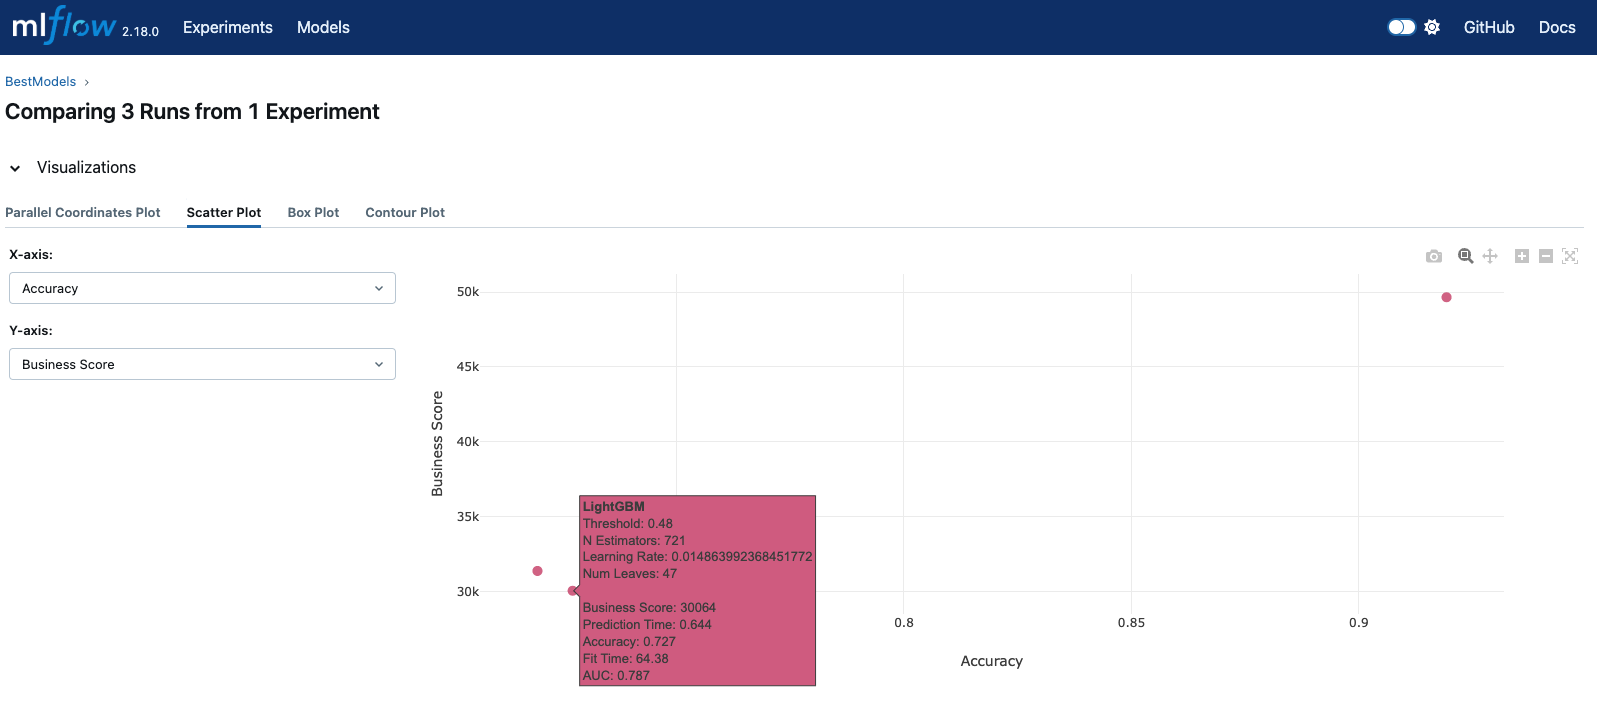

# Création csv test

In [35]:
df_test = df[df['TARGET'].isna()].drop(columns=['TARGET'])

In [36]:
print(df_test.shape)
df_test.head()

(48744, 772)


,SK_ID_CURR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,NAME_CONTRACT_TYPE_Cash loans,NAME_CONTRACT_TYPE_Revolving loans,CODE_GENDER_F,CODE_GENDER_M,FLAG_OWN_CAR_N,FLAG_OWN_CAR_Y,FLAG_OWN_REALTY_N,FLAG_OWN_REALTY_Y,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Group of people,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,"NAME_TYPE_SUITE_Spouse, partner",NAME_TYPE_SUITE_Unaccompanied,NAME_INCOME_TYPE_Businessman,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Maternity leave,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Academic degree,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_FAMILY_STATUS_Civil marriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Unknown,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_Co-op apartment,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents,OCCUPATION_TYPE_Accountants,OCCUPATION_TYPE_Cleaning staff,OCCUPATION_TYPE_Cooking staff,OCCUPATION_TYPE_Core staff,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_HR staff,OCCUPATION_TYPE_High skill tech staff,OCCUPATION_TYPE_IT staff,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_Low-skill Laborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicine staff,OCCUPATION_TYPE_Private service staff,OCCUPATION_TYPE_Realty agents,OCCUPATION_TYPE_Sales staff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Security staff,OCCUPATION_TYPE_Waiters/barmen staff,WEEKDAY_APPR_PROCESS_START_FRIDAY,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_PROCESS_START_THURSDAY,WEEKDAY_APPR_PROCESS_START_TUESDAY,WEEKDAY_APPR_PROCESS_START_WEDNESDAY,ORGANIZATION_TYPE_Advertising,ORGANIZATION_TYPE_Agriculture,ORGANIZATION_TYPE_Bank,ORGANIZATION_TYPE_Business Entity Type 1,ORGANIZA

In [44]:
df_test.to_csv('../Simulations/df_test.csv', index=False)